# Competitive Analysis – Customer Review Text Analytics

**Purpose:** Compare customer sentiment and themes between **Suck It Up Milkshake Co.** and **Brushy Mountain Smokehouse & Creamery** to surface actionable insights for product and service improvements.

**Data:** Synthetic review datasets (`suck_it_up_reviews.csv`, `brushy_mountain_reviews.csv`). These mirror the structure of my original project but contain no sensitive or proprietary information.

**Methods (high level):**
- Sentiment scoring → Positive / Neutral / Negative
- N-gram mining (top bigrams) to capture common phrases
- Topic modeling (LDA) to uncover recurring themes
- Visual comparisons by business (counts, distributions)

**Outputs / What to look for:**
- Sentiment distribution by business
- Top phrases and topics that differentiate the brands
- Brief takeaways highlighting strengths and opportunities


In [37]:
import csv
import random
import time
import nltk
nltk.download('punkt')
import pandas as pd
import spacy
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
from gensim import corpora, models
from nltk.corpus import stopwords
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import seaborn as sns
import matplotlib.pyplot as plt
from operator import itemgetter
import nltk
from sklearn.feature_extraction.text import CountVectorizer



# Setup
nltk.download("stopwords")
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nbcha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nbcha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
df_suck = pd.read_csv("suck_it_up_reviews.csv")
df_brushy = pd.read_csv("brushy_mountain_reviews.csv")

# Label the datasets
df_suck["Business"] = "Suck It Up"
df_brushy["Business"] = "Brushy Mountain"

# Combine
df_reviews = pd.concat([df_suck, df_brushy], ignore_index=True)


In [41]:
# Ensure clean column names and consistent sentiment order
for df in (df_suck, df_brushy):
    df.columns = [c.strip() for c in df.columns]

order = ["Positive", "Neutral", "Negative"]
df_suck["Sentiment Label"]   = pd.Categorical(df_suck["Sentiment Label"],   categories=order, ordered=True)
df_brushy["Sentiment Label"] = pd.Categorical(df_brushy["Sentiment Label"], categories=order, ordered=True)



In [44]:
avg_scores = df_reviews.groupby("Business")["Sentiment Score"].mean()
print("📊 Average Sentiment Score by Business:")
print(avg_scores)


📊 Average Sentiment Score by Business:
Business
Brushy Mountain    0.281671
Suck It Up         0.425417
Name: Sentiment Score, dtype: float64


In [47]:
import spacy
from operator import itemgetter
from collections import Counter

nlp = spacy.load("en_core_web_sm")

def compute_ngrams(sequence, n):
    return list(zip(*(sequence[i:] for i in range(n))))

def flatten_corpus(corpus):
    return ' '.join([doc.strip() for doc in corpus if isinstance(doc, str)])

def get_top_ngrams_spacy(corpus, ngram_val=2, limit=10):
    flat = flatten_corpus(corpus)
    doc = nlp(flat.lower())
    tokens = [token.text for token in doc if token.is_alpha]
    ngrams = compute_ngrams(tokens, ngram_val)
    freq_dist = Counter(ngrams)
    top = freq_dist.most_common(limit)
    return [(' '.join(gram), freq) for gram, freq in top]


In [48]:
print("Suck It Up Bigrams:", get_top_ngrams_spacy(df_suck["Text"], 2))
print("Brushy Mountain Bigrams:", get_top_ngrams_spacy(df_brushy["Text"], 2))


Suck It Up Bigrams: [('suck it', 32), ('it up', 32), ('up milkshake', 32), ('plenty of', 24), ('of flavors', 24), ('prices fair', 19), ('fair and', 19), ('excellent food', 18), ('food quick', 18), ('quick service', 18)]
Brushy Mountain Bigrams: [('brushy mountain', 48), ('mountain smokehouse', 48), ('smokehouse and', 48), ('and creamery', 48), ('long wait', 19), ('kids loved', 19), ('loved the', 19), ('the milkshakes', 19), ('milkshakes and', 19), ('fresh ingredients', 17)]


In [49]:
print("Suck It Up Trigrams:", get_top_ngrams_spacy(df_suck["Text"], 3))
print("Brushy Mountain Bigrams:", get_top_ngrams_spacy(df_brushy["Text"], 3))


Suck It Up Trigrams: [('suck it up', 32), ('it up milkshake', 32), ('plenty of flavors', 24), ('prices fair and', 19), ('excellent food quick', 18), ('food quick service', 18), ('small down home', 17), ('down home comfort', 17), ('home comfort with', 17), ('best ice cream', 16)]
Brushy Mountain Bigrams: [('brushy mountain smokehouse', 48), ('mountain smokehouse and', 48), ('smokehouse and creamery', 48), ('kids loved the', 19), ('loved the milkshakes', 19), ('the milkshakes and', 19), ('we love it', 16), ('love it here', 16), ('no long wait', 15), ('small down home', 15)]


In [51]:
print("Suck It Up Ngrams:", get_top_ngrams_spacy(df_suck["Text"], 4))
print("Brushy Mountain Bigrams:", get_top_ngrams_spacy(df_brushy["Text"], 4))


Suck It Up Ngrams: [('suck it up milkshake', 32), ('excellent food quick service', 18), ('small down home comfort', 17), ('down home comfort with', 17), ('best ice cream in', 16), ('ice cream in town', 16), ('kids loved the milkshakes', 16), ('loved the milkshakes and', 16), ('great food and fast', 13), ('food and fast polite', 13)]
Brushy Mountain Bigrams: [('brushy mountain smokehouse and', 48), ('mountain smokehouse and creamery', 48), ('kids loved the milkshakes', 19), ('loved the milkshakes and', 19), ('we love it here', 16), ('small down home comfort', 15), ('down home comfort with', 15), ('service was fast and', 13), ('friendly staff and clean', 12), ('staff and clean store', 12)]


In [53]:
def top_bigrams(df, text_col="Text", n=10):
    vec = CountVectorizer(lowercase=True, stop_words="english",
                          ngram_range=(2,2), min_df=2)
    X = vec.fit_transform(df[text_col].astype(str))
    counts = X.sum(axis=0).A1
    vocab = pd.Series(counts, index=vec.get_feature_names_out())
    return vocab.sort_values(ascending=False).head(n)

bigrams_suck = top_bigrams(df_suck)
bigrams_brushy = top_bigrams(df_brushy)

print("Top bigrams — Suck It Up:\n", bigrams_suck, "\n")
print("Top bigrams — Brushy Mountain:\n", bigrams_brushy)


Top bigrams — Suck It Up:
 suck milkshake    32
plenty flavors    24
prices fair       19
excellent food    18
food quick        18
quick service     18
small home        17
home comfort      17
nice people       16
ice cream         16
dtype: int64 

Top bigrams — Brushy Mountain:
 smokehouse creamery    48
brushy mountain        48
mountain smokehouse    48
loved milkshakes       19
kids loved             19
long wait              19
fresh ingredients      17
delicious shakes       15
home comfort           15
small home             15
dtype: int64


In [57]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models
import spacy

# Load spaCy model and define stop words
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words

# Preprocessing function
def preprocess_text(texts):
    processed = []
    for doc in nlp.pipe(texts, disable=["ner", "parser"]):
        tokens = [
            token.lemma_.lower()
            for token in doc
            if token.is_alpha and token.lemma_.lower() not in stop_words and len(token) > 2
        ]
        processed.append(tokens)
    return processed

# Topic modeling function
def run_topic_modeling(texts, label="Business", n_topics=2):
    print(f"\n🔍 Topic Modeling for {label}...")
    processed = preprocess_text(texts)
    dictionary = corpora.Dictionary(processed)
    corpus = [dictionary.doc2bow(doc) for doc in processed]

    lda_model = models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=n_topics,
        random_state=42,
        passes=15,
        alpha="auto",
        eta="auto"
    )

    for topic_id, topic in lda_model.print_topics(num_words=10):
        print(f"🧠 {label} - Topic {topic_id + 1}: {topic}")


In [59]:
# Split positive/negative
df_suck_pos = df_suck[df_suck["Sentiment Label"] == "Positive"]
df_suck_neg = df_suck[df_suck["Sentiment Label"] == "Negative"]
df_brushy_pos = df_brushy[df_brushy["Sentiment Label"] == "Positive"]
df_brushy_neg = df_brushy[df_brushy["Sentiment Label"] == "Negative"]

# Run topic modeling
run_topic_modeling(df_suck_pos["Text"].tolist(), label="Suck It Up - Positive")
run_topic_modeling(df_suck_neg["Text"].tolist(), label="Suck It Up - Negative")

run_topic_modeling(df_brushy_pos["Text"].tolist(), label="Brushy Mountain - Positive")
run_topic_modeling(df_brushy_neg["Text"].tolist(), label="Brushy Mountain - Negative")



🔍 Topic Modeling for Suck It Up - Positive...
🧠 Suck It Up - Positive - Topic 1: 0.072*"quick" + 0.068*"food" + 0.063*"milkshake" + 0.060*"service" + 0.048*"great" + 0.047*"fast" + 0.041*"suck" + 0.040*"excellent" + 0.036*"good" + 0.036*"cream"
🧠 Suck It Up - Positive - Topic 2: 0.068*"flavor" + 0.068*"plenty" + 0.055*"fair" + 0.055*"price" + 0.050*"small" + 0.050*"home" + 0.050*"comfort" + 0.038*"love" + 0.035*"fun" + 0.035*"atmosphere"

🔍 Topic Modeling for Suck It Up - Negative...
🧠 Suck It Up - Negative - Topic 1: 0.088*"long" + 0.088*"shake" + 0.069*"wait" + 0.069*"clean" + 0.069*"milkshake" + 0.069*"suck" + 0.069*"melted" + 0.049*"tone" + 0.049*"unfriendly" + 0.029*"seating"
🧠 Suck It Up - Negative - Topic 2: 0.104*"service" + 0.104*"slow" + 0.066*"counter" + 0.066*"messy" + 0.047*"tiny" + 0.047*"portion" + 0.028*"food" + 0.028*"poor" + 0.028*"cold" + 0.028*"confusing"

🔍 Topic Modeling for Brushy Mountain - Positive...
🧠 Brushy Mountain - Positive - Topic 1: 0.077*"love" + 0.06


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


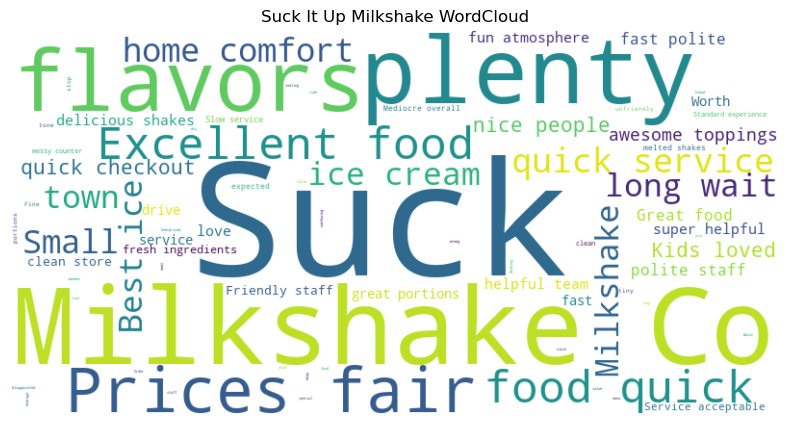

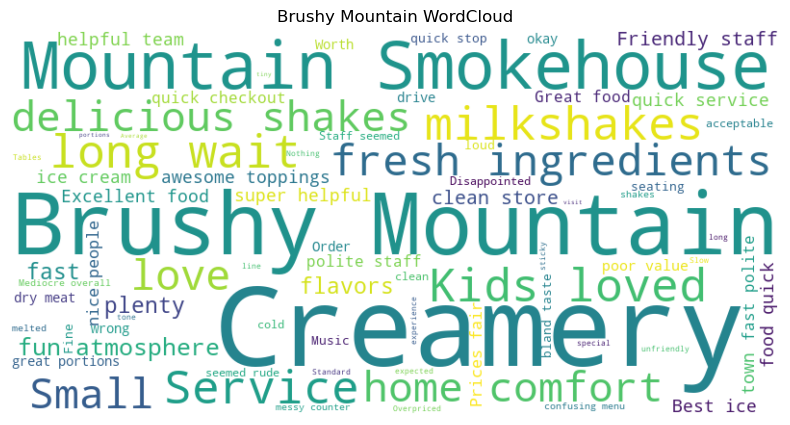

In [60]:
import sys
!{sys.executable} -m pip install wordcloud



from wordcloud import WordCloud

def show_wordcloud(text, title):
    wc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

show_wordcloud(df_suck["Text"], "Suck It Up Milkshake WordCloud")
show_wordcloud(df_brushy["Text"], "Brushy Mountain WordCloud")


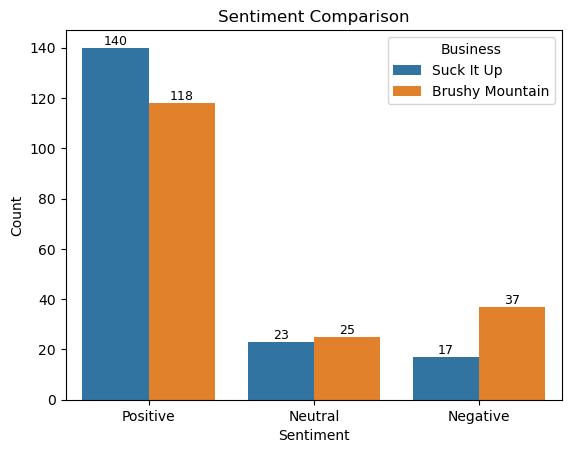

In [61]:
import seaborn as sns, matplotlib.pyplot as plt

ax = sns.countplot(data=df_reviews, x="Sentiment Label", hue="Business",
                   order=["Positive","Neutral","Negative"])
plt.title("Sentiment Comparison")
plt.xlabel("Sentiment")
plt.ylabel("Count")

# add % labels on bars
totals = df_reviews.groupby(["Business"])["Sentiment Label"].count().to_dict()
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        b = p.get_x() + p.get_width()/2
        ax.annotate(f"{int(height)}", (b, height), ha="center", va="bottom", fontsize=9, rotation=0)
plt.show()


In [62]:
def sentiment_share_by_business(df):
    return (
        df.groupby(["Business","Sentiment Label"])
          .size()
          .groupby(level=0).apply(lambda s: (s / s.sum() * 100).round(1))
          .unstack(fill_value=0)
          .reindex(columns=["Positive","Neutral","Negative"], fill_value=0)
          .sort_index()
    )

sent_tbl = sentiment_share_by_business(df_reviews)
sent_tbl


,Sentiment Label,Positive,Neutral,Negative
Business,Business,,,
Brushy Mountain,Brushy Mountain,65.6,13.9,20.6
Suck It Up,Suck It Up,77.8,12.8,9.4


In [63]:
def top_bigrams(df, text_col="Text", n=10):
    vec = CountVectorizer(lowercase=True, stop_words="english",
                          ngram_range=(2,2), min_df=2)
    X = vec.fit_transform(df[text_col].astype(str))
    counts = X.sum(axis=0).A1
    vocab = pd.Series(counts, index=vec.get_feature_names_out())
    return vocab.sort_values(ascending=False).head(n)

print("Top bigrams — Suck It Up:\n", top_bigrams(df_suck))
print("\nTop bigrams — Brushy Mountain:\n", top_bigrams(df_brushy))


Top bigrams — Suck It Up:
 suck milkshake    32
plenty flavors    24
prices fair       19
excellent food    18
food quick        18
quick service     18
small home        17
home comfort      17
nice people       16
ice cream         16
dtype: int64

Top bigrams — Brushy Mountain:
 smokehouse creamery    48
brushy mountain        48
mountain smokehouse    48
loved milkshakes       19
kids loved             19
long wait              19
fresh ingredients      17
delicious shakes       15
home comfort           15
small home             15
dtype: int64


In [64]:
su_pos = sent_tbl.loc["Suck It Up","Positive"]
bm_pos = sent_tbl.loc["Brushy Mountain","Positive"]

print(f"Headline: Positive reviews — Suck It Up {su_pos}%, Brushy Mountain {bm_pos}%")


Headline: Positive reviews — Suck It Up Business
Suck It Up    77.8
Name: Positive, dtype: float64%, Brushy Mountain Business
Brushy Mountain    65.6
Name: Positive, dtype: float64%
